# Implied Volatility of Index Options

In the article below, we will calculate the Implied Volatility of Future (Monthly) Options on the Index .STOXX50E (EURO STOXX 50 EUR PRICE INDEX) ('[EUREX](https://go.refinitiv.com/?u=Y3B1cmw6Ly9hcHBzLmNwLi9BcHBzL0luZGV4Lz9zPS5TVE9YWDUwJnN0PVJJQw%3D%3D&title=.STOXX50%20OV&key=bUq%2BNCiQGAcHQjSNEkJSlZLTgjo9cios8rz4heIBiU8%3D)'). To do so, we need to implement the Black-Scholes-Merton model. I have chosen to use the [py_vollib](py_vollib.black_scholes_merton.implied_volatility.implied_volatility) library for which the following parameters are needed:
* S (float) – underlying asset price
* K (float) – strike price
* sigma (float) – annualized standard deviation, or volatility, of the stock's returns. This is the square root of the quadratic variation of the stock's log price process, a measure of its volatility.
* t (float) – time to expiration in years
* r (float) – risk-free interest rate
* q (float) – annualized continuous dividend rate
* flag (str) – ‘c’ or ‘p’ for call or put.

In [143]:
import py_vollib  # pip install py_vollib
import py_vollib.black_scholes_merton.implied_volatility
# ========================================================================================
# Copyright © 2013-2014 Peter Jäckel.

# Permission to use, copy, modify, and distribute this software is freely granted,
# provided that this notice is preserved.

# WARRANTY DISCLAIMER
# The Software is provided "as is" without warranty of any kind, either express or implied,
# including without limitation any implied warranties of condition, uninterrupted use,
# merchantability, fitness for a particular purpose, or non-infringement.
# ========================================================================================

In [144]:
import refinitiv.data as rd
from refinitiv.data.content import historical_pricing
from refinitiv.data.content.historical_pricing import Intervals
from refinitiv.data.content.historical_pricing import Adjustments
from refinitiv.data.content.historical_pricing import MarketSession
from refinitiv.data.content import search

import numpy as np
import pandas as pd
import calendar
import pandas_market_calendars as mcal  # See `https://github.com/rsheftel/pandas_market_calendars/blob/master/examples/usage.ipynb` for info on this market calendar library
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import BDay
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px # This is just to see the implied vol graph when that field is available

rd.open_session(config_name="C:\\Example.DataLibrary.Python-main\\Example.DataLibrary.Python-main\\Configuration\\refinitiv-data.config.json")
rd.open_session("desktop.workspace")

<refinitiv.data.session.Definition object at 0x29acdc70 {name='workspace'}>

## Finding At The Money (ATM) Options

In this article, we will attempt to calculate the Implied Volatility (IV) for Future Options on 2 indecies (.STOXX50E & .SPX) trading 'ATM', meaning that the contract's strike price is at (or near - within x%) parity with (equal to) its current treading price (`TRDPRC_1`). We are also only looking for such Options expiroing within a set time window; allowing for the option 'forever', i.e.: that expire whenever after date of calculation. To do so, we 1st have to find the option in question. To find live Options, we best use the [Search API](https://developers.refinitiv.com/en/article-catalog/article/building-search-into-your-application-workflow). To find Expiered Options we will use functions created in Haykaz's amazing articles "[Finding Expired Options and Backtesting a Short Iron Condor Strategy](https://developers.refinitiv.com/en/article-catalog/article/finding-expired-options-and-backtesting-a-short-iron-condor-stra)" & "[Functions to find Option RICs traded on different exchanges](https://developers.refinitiv.com/en/article-catalog/article/functions-to-find-option-rics-traded-on-different-exchanges#1.1-Function-to-get-exchange-codes-where-the-option-is-traded)"

### Finding Live Options (using Search API)

Live Options, in this context, are Options that have not expiered at time of computation. To be explisit:

- 'time of calculation' refers here to the time for which the calculation is done, i.e.: if we compute today an IV for an Option as if it was 3 days ago, 'time of calculation' is 3 days ago.
- 'time of computation' refers here to the time when we are computing the values, i.e.: if we compute today an IV for an Option as if it was 3 days ago, 'time of computation' is today.

As afformentioned, to find live Options, we best use the [Search API](https://developers.refinitiv.com/en/article-catalog/article/building-search-into-your-application-workflow): Here we look for options on .STOXX50E that mature on the 3rd friday of Jully 2023, 2023-07-21:

In [145]:
response1 = search.Definition(
    view = search.Views.SEARCH_ALL, # To see what views are available: `help(search.Views)` & `search.metadata.Definition(view = search.Views.SEARCH_ALL).get_data().data.df.to_excel("SEARCH_ALL.xlsx")`
    query=".STOXX50E",
    select="DocumentTitle, RIC, StrikePrice, ExchangeCode, ExpiryDate, UnderlyingAsset, " +
            "UnderlyingAssetName, UnderlyingAssetRIC, ESMAUnderlyingIndexCode, RCSUnderlyingMarket" +
            "UnderlyingQuoteName, UnderlyingQuoteRIC",
    filter="RCSAssetCategoryLeaf eq 'Option' and RIC eq 'STX*' and DocumentTitle ne '*Weekly*'  " +
    "and CallPutOption eq 'Call' and ExchangeCode eq 'EUX' and " +
    "ExpiryDate ge 2022-07-10 and ExpiryDate lt 2023-07-22",  # ge (greater than or equal to), gt (greater than), lt (less than) and le (less than or equal to). These can only be applied to numeric and date properties.
    top=10000,
).get_data()
searchDf1 = response1.data.df

In [146]:
searchDf1

,DocumentTitle,RIC,StrikePrice,ExchangeCode,ExpiryDate,UnderlyingQuoteRIC
0,Eurex Dow Jones EURO STOXX 50 Index Option Dec...,STXE35000L2.EX,3500,EUX,2022-12-16,[.STOXX50E]
1,Eurex Dow Jones EURO STOXX 50 Index Option 350...,STXE35000C3.EX,3500,EUX,2023-03-17,[.STOXX50E]
2,Eurex Dow Jones EURO STOXX 50 Index Option 370...,STXE37000L2.EX,3700,EUX,2022-12-16,[.STOXX50E]
3,Eurex Dow Jones EURO STOXX 50 Index Option 400...,STXE40000L2.EX,4000,EUX,2022-12-16,[.STOXX50E]
4,Eurex Dow Jones EURO STOXX 50 Index Option 360...,STXE36000L2.EX,3600,EUX,2022-12-16,[.STOXX50E]
...,...,...,...,...,...,...
1546,Eurex EURO STOXX 50 Index Option 4475 Call Dec...,STXEEOM44750L2.EX,4475,EUX,2022-12-30,[.STOXX50E]
1547,Eurex EURO STOXX 50 Index Option 4450 Call Dec...,STXEEOM44500L2.EX,4450,EUX,2022-12-30,[.STOXX50E]
1548,Eurex EURO STOXX 50 Index Option 4375 Call Dec...,STXEEOM43750L2.EX,4375,EUX,2022-12-30,[.STOXX50E]
1549,Eurex EURO STOXX 50 Index Option 4425 Call Dec...,STXEEOM44250L2.EX,4425,EUX,2022-12-30,[.STOXX50E]


Let's say the current underlying price is 3331.7EUR, now we can pick the option with strike price closest to that, i.e.: the most 'At The Money'; note that this means that the option can be in or out the money, as long as it is the closest to at the money:

In [147]:
currentUnderlyingPrc = rd.get_history(
    universe=[searchDf1.UnderlyingQuoteRIC[0][0]],
    fields=["TRDPRC_1"],
    interval="tick").iloc[-1][0]

In [148]:
searchDf1.iloc[(searchDf1['StrikePrice']-currentUnderlyingPrc).abs().argsort()[:1]]

,DocumentTitle,RIC,StrikePrice,ExchangeCode,ExpiryDate,UnderlyingQuoteRIC
124,Eurex Dow Jones EURO STOXX 50 Index Option 347...,STXE34750K2.EX,3475,EUX,2022-11-18,[.STOXX50E]


In this instance, for this Call Option, 'STXE33500G3.EX', the strike price is 3350, higher than the spot price of our underlying which is 3331.7. The holder of this 'STXE33500G3.EX' option has the right (but not the obligation) to buy the underlying for 3350EUR, which, was the price of the underlying to stay the same till expiry (3331.7EUR on 2023-07-21), means a loss of (3350 - 3331.7 =) 18.3EUR. This option in this instance is 'Out-The-Money'.

N.B.: When using the Filter in Search and playing with dates, it is good to read the [API Playground Documentation](https://apidocs.refinitiv.com/Apps/ApiDocs#/details/L2Rpc2NvdmVyeS9zZWFyY2gvdjE=/Lw==/POST/README); it mentions that: "Dates are written in ISO datetime format. The time portion is optional, as is the timezone (assumed to be UTC unless otherwise specified). Valid examples include 2012-03-11T17\:13:55Z, 2012-03-11T17\:13:55, 2012-03-11T12\:00-03:30, 2012-03-11.":

<img src="Docs/SearchFilter.PNG">

#### Function for Expiration days

Most of the time, market agents will be interested in the next expiring Option, unless we are too close to it. We would not be interested, for example, in an option expiring in 1 hour, or even tomorrow, because that is so close (in time) that the information reflected in the Option's trades in the market does not represent future expectations of its underlying, but current expectations of it.

To implement such a logic, we need to know what are the expiry dates of the option that we are interested in. We are looking for a Python function narrowing our search to options expiring on the 3rd friday of any one month. For info on this function, please read articles "[Finding Expired Options and Backtesting a Short Iron Condor Strategy](https://developers.refinitiv.com/en/article-catalog/article/finding-expired-options-and-backtesting-a-short-iron-condor-stra)" & "[Functions to find Option RICs traded on different exchanges](https://developers.refinitiv.com/en/article-catalog/article/functions-to-find-option-rics-traded-on-different-exchanges#1.1-Function-to-get-exchange-codes-where-the-option-is-traded)"

In [149]:
def get_exp_dates(year, days=True, mcal_get_calendar='EUREX'):
    '''
    get_exp_dates Version 2.0:

    This function gets expiration dates for a year for NDX options, which are the 3rd Fridays of each month.

    Changes
    ----------------------------------------------
    Changed from Version 1.0 to 2.0: Jonathan Legrand chaned Haykaz Aramyan's original code to allow
        (i) for the function's holiday argument to be changed, and defaulted to 'EUREX' as opposed to 'CBOE_Index_Options' and
        (ii) for the function to output full date objects as opposed to just days of the month if agument days=True.

    Dependencies
    ----------------------------------------------
    Python library 'pandas_market_calendars' version 3.2

    Parameters
    -----------------------------------------------
    Input:
        year(int): year for which expiration days are requested

        mcal_get_calendar(str): String of the calendar for which holidays have to be taken into account. More on this calendar (link to Github chacked 2022-10-11): https://github.com/rsheftel/pandas_market_calendars/blob/177e7922c7df5ad249b0d066b5c9e730a3ee8596/pandas_market_calendars/exchange_calendar_cboe.py
            Default: mcal_get_calendar='EUREX'

        days(bool): If True, only days of the month is outputed, else it's dataeime objects
            Default: days=True

    Output:
        dates(dict): dictionary of expiration days for each month of a specified year in datetime.date format.
    '''

    # get CBOE market holidays
    EUREXCal = mcal.get_calendar(mcal_get_calendar)
    holidays = EUREXCal.holidays().holidays

    # set calendar starting from Saturday
    c = calendar.Calendar(firstweekday=calendar.SATURDAY)

    # get the 3rd Friday of each month
    exp_dates = {}
    for i in range(1, 13):
        monthcal = c.monthdatescalendar(year, i)
        date = monthcal[2][-1]
        # check if found date is an holiday and get the previous date if it is
        if date in holidays:
            date = date + timedelta(-1)
        # append the date to the dictionary
        if year in exp_dates:
            ### Changed from original code from here on by Jonathan Legrand on 2022-10-11
            if days: exp_dates[year].append(date.day)
            else: exp_dates[year].append(date)
        else:
            if days: exp_dates[year] = [date.day]
            else: exp_dates[year] = [date]
    return exp_dates

In [150]:
fullDates = get_exp_dates(2022, days=False)
dates = get_exp_dates(2022)
fullDatesStrDict = {i: [fullDates[i][j].strftime('%Y-%m-%d')
                        for j in range(len(fullDates[i]))]
                    for i in list(fullDates.keys())}
fullDatesDayDict = {i: [fullDates[i][j].day
                        for j in range(len(fullDates[i]))]
                    for i in list(fullDates.keys())}

In [151]:
print(fullDates)

{2022: [datetime.date(2022, 1, 21), datetime.date(2022, 2, 18), datetime.date(2022, 3, 18), datetime.date(2022, 4, 14), datetime.date(2022, 5, 20), datetime.date(2022, 6, 17), datetime.date(2022, 7, 15), datetime.date(2022, 8, 19), datetime.date(2022, 9, 16), datetime.date(2022, 10, 21), datetime.date(2022, 11, 18), datetime.date(2022, 12, 16)]}


In [152]:
print(fullDatesStrDict)

{2022: ['2022-01-21', '2022-02-18', '2022-03-18', '2022-04-14', '2022-05-20', '2022-06-17', '2022-07-15', '2022-08-19', '2022-09-16', '2022-10-21', '2022-11-18', '2022-12-16']}


In [153]:
print(dates)

{2022: [21, 18, 18, 14, 20, 17, 15, 19, 16, 21, 18, 16]}


In [154]:
print(fullDatesDayDict)

{2022: [21, 18, 18, 14, 20, 17, 15, 19, 16, 21, 18, 16]}


#### Function to find the next expiring Option outside the next x day window

Most of the time, market agents will be interested in the next expiring Option, unless we are too close to it. We would not be interested, for example, in an option expiring in 1 hour, or even tomorrow, because that is so close (in time) that the information reflected in the Option's trades in the market does not represent future expectations of its underlying, but current expectations of it.

E.g.: I would like to know what is the next Future (Monthly) Option (i) on the Index '.STOXX50E' (ii) closest to ATM (i.e.: with an underlying spot price closest to the option's strike price) (ii) Expiring in more than x days (i.e.: not too close to calculated time 't'), let's say 15 days:

In [155]:
x = 15

In [156]:
timeOfCalcDatetime = datetime.now()  # For now, we will focuss on the use-case where we are calculating values for today; later we will allow for it historically for any day going back a few business days.
timeOfCalcStr = datetime.now().strftime('%Y-%m-%d')
timeOfCalcStr

'2022-10-18'

In [157]:
fullDatesAtTimeOfCalc = get_exp_dates(timeOfCalcDatetime.year, days=False)  # `timeOfCalcDatetime.year` here is 2022
fullDatesAtTimeOfCalcDatetime = [
    datetime(i.year, i.month, i.day)
    for i in fullDatesAtTimeOfCalc[list(fullDatesAtTimeOfCalc.keys())[0]]]

In [158]:
print(fullDatesAtTimeOfCalcDatetime)

[datetime.datetime(2022, 1, 21, 0, 0), datetime.datetime(2022, 2, 18, 0, 0), datetime.datetime(2022, 3, 18, 0, 0), datetime.datetime(2022, 4, 14, 0, 0), datetime.datetime(2022, 5, 20, 0, 0), datetime.datetime(2022, 6, 17, 0, 0), datetime.datetime(2022, 7, 15, 0, 0), datetime.datetime(2022, 8, 19, 0, 0), datetime.datetime(2022, 9, 16, 0, 0), datetime.datetime(2022, 10, 21, 0, 0), datetime.datetime(2022, 11, 18, 0, 0), datetime.datetime(2022, 12, 16, 0, 0)]


In [159]:
expiryDateOfInt = [i for i in fullDatesAtTimeOfCalcDatetime
                   if i > timeOfCalcDatetime + relativedelta(days=x)][0]
expiryDateOfInt

datetime.datetime(2022, 11, 18, 0, 0)

Now we can look for the one option we're after:

In [160]:
response2 = search.Definition(
    view = search.Views.SEARCH_ALL, # To see what views are available: `help(search.Views)` & `search.metadata.Definition(view = search.Views.SEARCH_ALL).get_data().data.df.to_excel("SEARCH_ALL.xlsx")`
    query=".STOXX50E",
    select="DocumentTitle, RIC, StrikePrice, ExchangeCode, ExpiryDate, UnderlyingAsset, " +
            "UnderlyingAssetName, UnderlyingAssetRIC, ESMAUnderlyingIndexCode, RCSUnderlyingMarket" +
            "UnderlyingQuoteName, UnderlyingQuoteRIC",
    filter="RCSAssetCategoryLeaf eq 'Option' and RIC eq 'STX*' and DocumentTitle ne '*Weekly*' " +
    "and CallPutOption eq 'Call' and ExchangeCode eq 'EUX' and " +
    f"ExpiryDate ge {(expiryDateOfInt - relativedelta(days=1)).strftime('%Y-%m-%d')} " +
    f"and ExpiryDate lt {(expiryDateOfInt + relativedelta(days=1)).strftime('%Y-%m-%d')}",  # ge (greater than or equal to), gt (greater than), lt (less than) and le (less than or equal to). These can only be applied to numeric and date properties.
    top=10000,
).get_data()
searchDf2 = response2.data.df

In [161]:
searchDf2

,DocumentTitle,RIC,StrikePrice,ExchangeCode,ExpiryDate,UnderlyingQuoteRIC
0,Eurex Dow Jones EURO STOXX 50 Index Option 350...,STXE35000K2.EX,3500,EUX,2022-11-18,[.STOXX50E]
1,Eurex Dow Jones EURO STOXX 50 Index Option 330...,STXE33000K2.EX,3300,EUX,2022-11-18,[.STOXX50E]
2,Eurex Dow Jones EURO STOXX 50 Index Option 300...,STXE30000K2.EX,3000,EUX,2022-11-18,[.STOXX50E]
3,Eurex Dow Jones EURO STOXX 50 Index Option 342...,STXE34250K2.EX,3425,EUX,2022-11-18,[.STOXX50E]
4,Eurex Dow Jones EURO STOXX 50 Index Option 370...,STXE37000K2.EX,3700,EUX,2022-11-18,[.STOXX50E]
...,...,...,...,...,...,...
132,Eurex Dow Jones EURO STOXX 50 Index Option 700...,STXE70000K2.EX,7000,EUX,2022-11-18,[.STOXX50E]
133,Eurex Dow Jones EURO STOXX 50 Index Option 900...,STXE90000K2.EX,9000,EUX,2022-11-18,[.STOXX50E]
134,Eurex Dow Jones EURO STOXX 50 Index Option 100...,STXE100000K2.EX,10000,EUX,2022-11-18,[.STOXX50E]
135,Eurex Dow Jones EURO STOXX 50 Index Option 232...,STXE23250K2.EX,2325,EUX,2022-11-18,[.STOXX50E]


And again, we can collect the closest to ATM:

In [162]:
# Remember that we set `currentUnderlyingPrc = 3331.7`
searchDf2.iloc[(searchDf2['StrikePrice']-currentUnderlyingPrc).abs().argsort()[:1]]

,DocumentTitle,RIC,StrikePrice,ExchangeCode,ExpiryDate,UnderlyingQuoteRIC
7,Eurex Dow Jones EURO STOXX 50 Index Option 347...,STXE34750K2.EX,3475,EUX,2022-11-18,[.STOXX50E]


Now we have our instrument:

In [163]:
instrument = searchDf2.iloc[(searchDf2['StrikePrice']-currentUnderlyingPrc).abs().argsort()[:1]].RIC.values[0]
instrument

'STXE34750K2.EX'

### Finding Expiered Options

#### For Options expiring in a specific number of days

Future Option Contracts are issued with exchange-specific expiry date rules. We focus here on ".STOXX50E" and ".SPX" index's options which are issued and traded in the EUREX and OPRA exchanges respectivly, both of which only issue options expiring on the 3rd friday of any one month. For this we will use functions created in Haykaz's amazing articles "[Finding Expired Options and Backtesting a Short Iron Condor Strategy](https://developers.refinitiv.com/en/article-catalog/article/finding-expired-options-and-backtesting-a-short-iron-condor-stra)" & "[Functions to find Option RICs traded on different exchanges](https://developers.refinitiv.com/en/article-catalog/article/functions-to-find-option-rics-traded-on-different-exchanges#1.1-Function-to-get-exchange-codes-where-the-option-is-traded)":

#### Function for Expiration days

For info on this function, please read articles "[Finding Expired Options and Backtesting a Short Iron Condor Strategy](https://developers.refinitiv.com/en/article-catalog/article/finding-expired-options-and-backtesting-a-short-iron-condor-stra)" & "[Functions to find Option RICs traded on different exchanges](https://developers.refinitiv.com/en/article-catalog/article/functions-to-find-option-rics-traded-on-different-exchanges#1.1-Function-to-get-exchange-codes-where-the-option-is-traded)"

In [164]:
# def get_exp_dates(year, days=True, mcal_get_calendar='EUREX'):
#     '''
#     get_exp_dates Version 2.0:

#     This function gets expiration dates for a year for NDX options, which are the 3rd Fridays of each month.

#     Changes
#     ----------------------------------------------
#     Changed from Version 1.0 to 2.0: Jonathan Legrand chaned Haykaz Aramyan's original code to allow
#         (i) for the function's holiday argument to be changed, and defaulted to 'EUREX' as opposed to 'CBOE_Index_Options' and
#         (ii) for the function to output full date objects as opposed to just days of the month if agument days=True.

#     Dependencies
#     ----------------------------------------------
#     Python library 'pandas_market_calendars' version 3.2

#     Parameters
#     -----------------------------------------------
#     Input:
#         year(int): year for which expiration days are requested

#         mcal_get_calendar(str): String of the calendar for which holidays have to be taken into account. More on this calendar (link to Github chacked 2022-10-11): https://github.com/rsheftel/pandas_market_calendars/blob/177e7922c7df5ad249b0d066b5c9e730a3ee8596/pandas_market_calendars/exchange_calendar_cboe.py
#             Default: mcal_get_calendar='EUREX'

#         days(bool): If True, only days of the month is outputed, else it's dataeime objects
#             Default: days=True

#     Output:
#         dates(dict): dictionary of expiration days for each month of a specified year in datetime.date format.
#     '''

#     # get CBOE market holidays
#     EUREXCal = mcal.get_calendar(mcal_get_calendar)
#     holidays = EUREXCal.holidays().holidays

#     # set calendar starting from Saturday
#     c = calendar.Calendar(firstweekday=calendar.SATURDAY)

#     # get the 3rd Friday of each month 
#     exp_dates = {}
#     for i in range(1, 13):
#         monthcal = c.monthdatescalendar(year, i)
#         date = monthcal[2][-1]
#         # check if found date is an holiday and get the previous date if it is
#         if date in holidays:
#             date = date + timedelta(-1)
#         # append the date to the dictionary
#         if year in exp_dates:
#             ### Changed from original code from here on by Jonathan Legrand on 2022-10-11
#             if days: exp_dates[year].append(date.day)
#             else: exp_dates[year].append(date)
#         else:
#             if days: exp_dates[year] = [date.day]
#             else: exp_dates[year] = [date]
#     return exp_dates

In [165]:
# fullDates = get_exp_dates(2022, days=False)
# dates = get_exp_dates(2022)
# fullDatesStrDict = {i: [fullDates[i][j].strftime('%Y-%m-%d') for j in range(len(fullDates[i]))] for i in list(fullDates.keys())}
# fullDatesDayDict = {i: [fullDates[i][j].day for j in range(len(fullDates[i]))] for i in list(fullDates.keys())}

In [166]:
# print(fullDates)

In [167]:
# dates

In [168]:
# print(fullDatesDayDict)

#### Function for Transaction days

In [169]:
# def get_trans_days(year, trans_day = 'first', mcal_get_calendar='EUREX'):
#     '''get_trans_days Version 2.0: get_trans_days(year, trans_day = 'first', mcal_get_calendar='EUREX')
#     This function gets transaction days for each month of a specified year.

#     Changes
#     ----------------------------------------------
#     Changed from Version 1.0 to 2.0: Jonathan Legrand chaned Haykaz Aramyan's original code to allow for the function's holiday argument to be changed, and defaulted to 'EUREX' as opposed to 'CBOE_Index_Options'


#     Dependencies
#     ----------------------------------------------
#     Python library 'pandas_market_calendars' version 3.2

#     Parameters
#     -----------------------------------------------
#     Input:
#         year (int): year for which transaction days are requested
#         trans_day (str, default = 'first'): takes either 'first' or 'third' indicating to the first business day or the 3rd Friday of a month respectively

#     mcal_get_calendar(str): String of the calendar for which holidays have to be taken into account. More on this calendar (link to Github chacked 2022-10-11): https://github.com/rsheftel/pandas_market_calendars/blob/177e7922c7df5ad249b0d066b5c9e730a3ee8596/pandas_market_calendars/exchange_calendar_cboe.py
#             Default: mcal_get_calendar='EUREX'

#     Output:
#         trans_days (list): list of days for 12 month
#     '''
#     # get the first business day of each month
#     if trans_day == 'first':
#         CBOE = mcal.get_calendar(mcal_get_calendar)
#         holidays = CBOE.holidays().holidays
        
#         # set start and end day ranges
#         start_date = str(year) + '-01' +'-01'
#         end_date = str(year) + '-12' + '-31'
#         trans_days = []
        
#         for date in pd.date_range(start_date, end_date, freq='BMS'):
#             # get the first day after the weekend after checking for holiday
#             while date.isoweekday() > 5 or date in holidays:
#                 date += timedelta(1)
#             # add found day to the list
#             trans_days.append(date.date().day)
            
#     # get the 3rd Friday for each month by calling function "get_exp_dates"
#     elif trans_day == 'third':
#         trans_days = get_exp_dates(year)[year]
#     else:
#         print('Please input "first" or "third" for transaction day')
#         return
#     return trans_days

#### Function to get adjustment factor of stock split
For info on this function, please read articles "[Finding Expired Options and Backtesting a Short Iron Condor Strategy](https://developers.refinitiv.com/en/article-catalog/article/finding-expired-options-and-backtesting-a-short-iron-condor-stra)" & "[Functions to find Option RICs traded on different exchanges](https://developers.refinitiv.com/en/article-catalog/article/functions-to-find-option-rics-traded-on-different-exchanges#1.1-Function-to-get-exchange-codes-where-the-option-is-traded)"

In [170]:
# def adjustment_factor(corp_event, year=None, date=None, trans_day='first'):
#     '''
#     This function gets adjustment factor(s) of stock split for a given asset. If no split event is happened during the requested period
#     function returns 1(if date argument is used) or list of twelve 1s (if year argument is used), which assumes no adjustment in prices.
    
#     Dependencies
#     ----------------------------------------------
#     Python library 'pandas_market_calendars' version 3.2

#     Parameters
#     -----------------------------------------------
#     Input:
#         asset (str): RIC code of the asset
#         year (int): year for which stock split events are requested
#         date (str with date (YYYY-MM-DD) format): Date as of which stock split events are requested
#         trans_day (str, default = 'first'): indicates the date of the transaction for get_trans_days function
#     Output:
#         adj_factor (float): This is returned in case of date argument is used. The output is the Adjustment factor after split
#         adj_factors(list): This is returned in case of year argument is used. The output is the list of Adjustment factors after split for each month
#     ''' 
#     # if there is no stock split corporate event
#     if corp_event is None or corp_event['TR.CAEffectiveDate'][0] is None:
#         if year != None and date == None:
#             # return list of 1s if year argument is used
#             adj_factors = 12 * [1]
#             return adj_factors
#         elif date != None and year == None:
#             # return 1 if exact date argument is used
#             adj_factor = 1
#             return adj_factor
#         else:
#             print('Either Year or exact date needs to be passed to the function')
#     # if there is an event adjustment factor(s) is(are) calculated
#     else: 
#         if year != None and date == None: # in case of year argument is used
#             # request transaction dates
#             trans_days = get_trans_days(year, trans_day)
#             adj_factors = []
#             for i in range(1,13):
#                 # get exp_dates and use it as a request date for stock split corporate events
#                 exp_date = str(year) + '-' + str(i) + '-' + str(trans_days[i - 1])
#                 # initiate adj_factor with 1
#                 adj_factor = 1
#                 # we first check if the expiration date of option is after or before the adjustment date
#                 for j in reversed(range(len(corp_event))):
#                     # if expiration date is smaller than adjustment date then we need adjustment
#                     if pd.to_datetime(exp_date).strftime('%Y-%m-%d') < corp_event['TR.CAEffectiveDate'][j]:
#                         adj_factor = float(corp_event['TR.CAAdjustmentFactor'][j]) * adj_factor # we should consider all adjustment factors which are after the expiration day
#                 # append adjustment factor of the month to the list
#                 adj_factors.append(adj_factor)              
#             return adj_factors
    
#         elif date != None and year == None: #in case exact date  argument is ued
#             adj_factor = 1
#             for j in reversed(range(len(corp_event))):
#                 # if expiration date is smaller than adjustment date then we need adjustment
#                 if pd.to_datetime(date).strftime('%Y-%m-%d') < corp_event['TR.CAEffectiveDate'][j]:
#                     adj_factor = float(corp_event['TR.CAAdjustmentFactor'][j]) * adj_factor
#             return adj_factor
#         else:
#             print('Either Year or exact date needs to be passed to the function')

#### Function to get potential RICs

In [171]:
# def get_potential_rics(year, trans_day, asset, OTM_size, diff, opt_type, adjFactors=True):
#     '''get_potential_rics Version 2.0: get_potential_rics(year, trans_day, asset, OTM_size, diff, opt_type, adjFactors=True)
#     This function returns the list of potential option RICs for a specified year reconstructed based on Refinitiv RIC and option trading rules.

#     Changes
#     ----------------------------------------------
#     Changed from Version 1.0 to 2.0: Jonathan Legrand chaned Haykaz Aramyan's original code to allow for adjustment factor to be ommited if wanted, via addition of argument 'adjFactors'

#     Dependencies
#     ----------------------------------------------
#     Python library 'Refinitiv Dataplatform' version 1.0.0a8.post1

#     Parameters
#     -----------------------------------------------
#     Input:
#         year (int): year for which transaction days are requested
#         trans_day (str, default = 'first'): takes either 'first' or 'third' indicating to the first business day or the 3rd Friday of a month respectively
#         asset (str): RIC code of the asset
#         OTM_size (int): percentage number indicating how far away is the strike price from the price of the underlying asset
#         diff (int): Tolarated difference in OTM to construct upper and lower bounds of strike prices
#         opt_type (str): takes either "call" or "put"
#         adjFactors (bool): If True, an adjustment factor using the function 'adjustment_factor' (which must be pre-defined) will apply.

#     Output:
#         potential_RICs (dict): dictionary containing potential RICs for each month with strike prices from the lower to upper bounds of strikes
#         strikes (list): list of the strike prices calculated based on OTM size for each month
#     '''

#     # open file to report log of the function output
#     report = open("Log report.txt", "a")

#     # call functions to get expiration and transaction days
#     trans_days = get_trans_days(year, trans_day)
#     trans_days_prev = get_trans_days(year - 1, trans_day)
#     dates = get_exp_dates(year) 

#     # trim underlying asset's RIC to get the required part for option RIC
#     if asset[0] == '.': # check if the asset is an index or an equity
#         asset_name = asset[1:] # get the asset name - we remove "." symbol for index options
#         if adjFactors: adj_factors = 12 * [1] # set adjustment factors to be equal to 1 for each month (no stock split corporate event is applicable to indices)
#         else: pass
#     else:
#         asset_name = asset.split('.')[0] # we need only the first part of the RICs for equities
#         # get list of corporate events for equities
#         corp_event = rd.get_data(
#             universe=asset,
#             fields=["TR.CAEffectiveDate", "TR.CAAdjustmentFactor", "TR.CAAdjustmentType"],
#             parameters={
#                 "CAEventType": "SSP",
#                 "SDate": datetime.today().strftime("%Y-%m-%d"),
#                 "EDate": "-50Y"})
#         # run adjustment_factor function to get the factors
#         if adjFactors: adj_factors = adjustment_factor(corp_event, year = year, trans_day = trans_day)
#         else: pass

#     # define expiration month codes to be used after "^" sign
#     exp = ['A', 'B', 'C', 'D','E','F','G', 'H', 'I', 'J', 'K', 'L']
#     potential_RICs = {}
#     strikes = []

#     # construct potential RICs for each month of a specified year
#     for j in range(1, 13):
#         # get day of expiration for a month
#         day = dates[year][j - 1]
#         # get date of price request, which is in the previous month of expiration 
#         if j != 1:
#             date = str(year) + '-' + str(j - 1) + '-' + str(trans_days[j - 2])
#         if j == 1: # for January, we need to subtract a year along with the month
#             date = str(year - 1) + '-' + str(j + 11) + '-' + str(trans_days_prev[j + 10])    
#         # get price of underlying asset as of the transaction date

#         # get the corresponding adjustment factor for the month
#         if adjFactors: adj_factor = adj_factors[j-1]
#         else: pass

#         price = rd.get_data(asset,
#                             fields = ['TR.PriceClose'],
#                             parameters = {'SDate': date})
#         if adjFactors: price = float(price.iloc[0,1]) / adj_factor # adjust prices by the adjustment factor. if no sptick split events adj_factor = 1
#         else: price = float(price.iloc[0,1])

#         # calculate the strike price for call options
#         if opt_type.lower() == 'call':
#             strike = price + price * OTM_size / 100
#             # define expiration month codes for call options while also considering the strike price
#             if strike > 999.999:
#                 exp_codes_call = ['a', 'b', 'c', 'd','e','f','g', 'h', 'i', 'j', 'k', 'l']
#             else:
#                 exp_codes_call = ['A', 'B', 'C', 'D','E','F','G', 'H', 'I', 'J', 'K', 'L']
#             # get expiration month code for a month
#             exp_month = exp_codes_call[j-1]

#         # calculate the strike price and get expiration month code for a month for put options
#         elif opt_type.lower() == 'put':
#             strike = price - price * OTM_size/100
#             if strike > 999.999:
#                 exp_codes_put = ['m', 'n', 'o', 'p','q','r','s', 't', 'u', 'v', 'w', 'x'] 
#             else:
#                 exp_codes_put = ['M', 'N', 'O', 'P','Q','R','S', 'T', 'U', 'V', 'W', 'X']
#             exp_month = exp_codes_put[j-1]

#         strikes.append(int(round(strike, 0)))  # append the calculated strike price to the list of strikes

#         # calculate lower and upper bounds for strikes considering the value of the strike
#         if strike > 999.999:
#             step = 5  # we loop over strikes with a step 5 for larger strikes
#             strike_ub = int(round((strike + strike * diff / 100),-1))
#             strike_lb = int(round((strike - strike * diff / 100),-1))
#         else:
#             step = 1  # we loop over strikes with a step 1 for smaller strikes
#             strike_ub = int(strike + strike * diff / 100)
#             strike_lb = int(strike - strike * diff / 100)

#         # construct RICs for each strike from the lower to upper bound ranges of strikes
#         for n in range(strike_lb, strike_ub + step, step):
#             k = None  # for strikes < 1000 along with 1 step increment change in strikes we do 0.5 point increment change which 
#                       #allows us to consider strikes with decimal points. This is important to get closer OTMs for smaller valued assets.
#             # here we construct option RICs by adding together all the RIC components
#             # Please note some of the components are different depending on the strike value
#             plc_holdr1 = asset_name + exp_month + str(day) + str(year)[-2:]
#             plc_holdr2 = exp[j - 1] + str(year)[-2:]
#             if n < 10:
#                 z = plc_holdr1 + '00' + str(n) + '00.U^' + plc_holdr2# for integer steps
#                 k = plc_holdr1 + '00' + str(n) + '50.U^' + plc_holdr2# for decimal steps
#             elif n >= 10 and n < 100:
#                 z = plc_holdr1 + '0' + str(n) + '00.U^' + plc_holdr2
#                 k = plc_holdr1 + '0' + str(n) + '50.U^' + plc_holdr2
#             if n >= 100 and n < 1000:
#                 z = plc_holdr1 + str(n) + '00.U^' + plc_holdr2  
#                 k = plc_holdr1 + str(n) + '50.U^' + plc_holdr2
#             elif n >= 1000 and n < 10000:
#                 z = plc_holdr1 + str(n) + '0.U^' + plc_holdr2
#             elif n >= 10000 and n < 20000:
#                 z = plc_holdr1 + 'A' + str(n)[-4:] + '.U^' + plc_holdr2
#             elif n >= 20000 and n < 30000:
#                 z = plc_holdr1 + 'B' + str(n)[-4:] + '.U^' + plc_holdr2
#             elif n >= 30000 and n < 40000:
#                 z = plc_holdr1 + 'C' + str(n)[-4:] + '.U^' + plc_holdr2
#             elif n >= 40000 and n < 50000:
#                 z = plc_holdr1 + 'D' + str(n)[-4:] + '.U^' + plc_holdr2

#             # append RICs with integer strikes to the dictionary
#             if j in potential_RICs:
#                 potential_RICs[j].append(z)
#                 # append RICs with decimal point strikes to the dictionary
#                 if k is not None:
#                     potential_RICs[j].append(k)
#             else:
#                 potential_RICs[j] = [z]
#                 if k is not None:
#                     potential_RICs[j].append(k)  

#     # report funtion results and close the log file
#     now = {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
#     report.write(f'{now}: Potential RICs for {opt_type} options with {OTM_size}% OTM for {year} are constructed\n')
#     report.close()
#     return potential_RICs, strikes

In [172]:
# call_RICs, call_strikes = get_potential_rics(
#     year=2020, trans_day='first', asset='.SPX', OTM_size=5,
#     diff=3, opt_type='call', adjFactors=False)
# print(call_RICs)

In [173]:
# call_RICs

In [174]:
# def get_exp_month(exp_date, opt_type):
#     """
#     This function takes the expiration date and option type as an input and
#     returns the expiration month code for the option, which is further used
#     to construct RICs
#     """

#     # define option expiration identifiers
#     ident = {'1': {'exp': 'A','C': 'A', 'P': 'M'}, 
#            '2': {'exp': 'B', 'C': 'B', 'P': 'N'}, 
#            '3': {'exp': 'C', 'C': 'C', 'P': 'O'}, 
#            '4': {'exp': 'D', 'C': 'D', 'P': 'P'},
#            '5': {'exp': 'E', 'C': 'E', 'P': 'Q'},
#            '6': {'exp': 'F', 'C': 'F', 'P': 'R'},
#            '7': {'exp': 'G', 'C': 'G', 'P': 'S'}, 
#            '8': {'exp': 'H', 'C': 'H', 'P': 'T'}, 
#            '9': {'exp': 'I', 'C': 'I', 'P': 'U'}, 
#            '10': {'exp': 'J', 'C': 'J', 'P': 'V'}, 
#            '11': {'exp': 'K', 'C': 'K', 'P': 'W'}, 
#            '12': {'exp': 'L', 'C': 'L', 'P': 'X'}}

#     # get expiration month code for a month
#     if opt_type.upper() == 'C':
#         exp_month = ident[str(exp_date.month)]['C']
#     elif opt_type.upper() == 'P':
#         exp_month = ident[str(exp_date.month)]['P']

#     return ident, exp_month

## Refinitiv-provided Daily Implied Volatility

Refinitiv provides pre-calculated Implied Volatility values, but they are daily, and we will look into calculating them in higher frequencies:

In [175]:
# instrument_1 = 'SPXv212240000.U'
# instrument_2 = 'STXE35500J2.EX'  # Eurex Dow Jones EURO STOXX 50 Index Option 3550 Call Oct 2022, Stock Index Cash Option, Underlying RIC: .STOXX50E
# instrument_3 = 'SPXj212240000.U'

In [176]:
start = (timeOfCalcDatetime - pd.tseries.offsets.BDay(7)).strftime('%Y-%m-%dT%H:%M:%S.%f')  # '2022-10-05T07:30:00.000'
end = (datetime.now() - timedelta(minutes=0)).strftime('%Y-%m-%dT%H:%M:%S.%f') #  '2022-09-09T20:00:00.000'

In [177]:
_RefDailyImpVolDf = historical_pricing.events.Definition(instrument, fields=['IMP_VOLT'], count=2000).get_data()

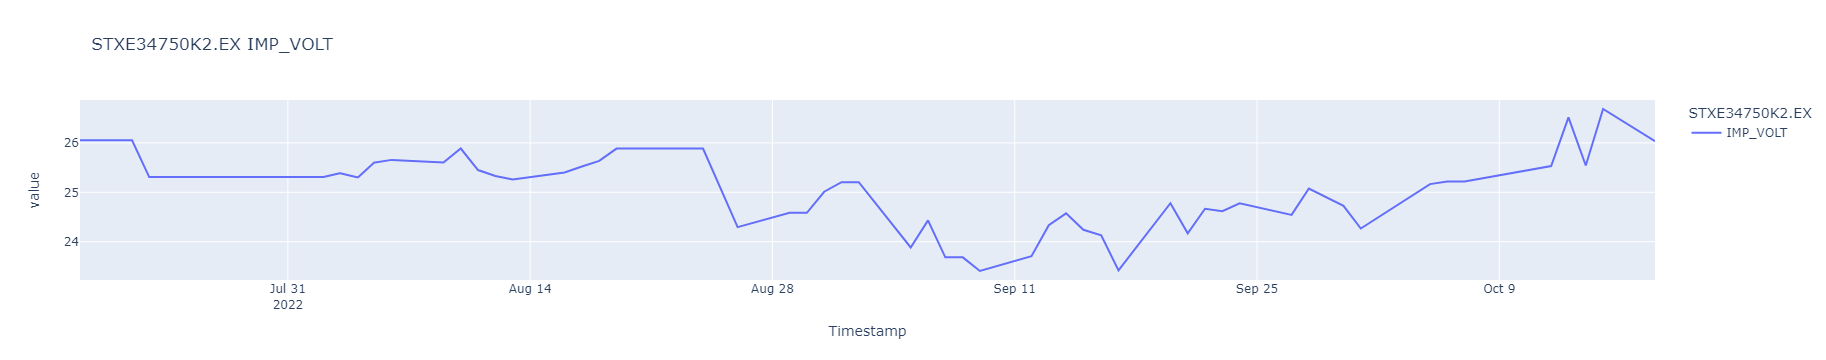

In [178]:
try: RefDailyImpVolDf = _RefDailyImpVolDf.data.df.drop(['EVENT_TYPE'], axis=1) # In codebook, this line is needed
except: RefDailyImpVolDf = _RefDailyImpVolDf.data.df # If outside of codebook
fig = px.line(RefDailyImpVolDf, title = RefDailyImpVolDf.columns.name + " " + RefDailyImpVolDf.columns[0]) # This is just to see the implied vol graph when that field is available
fig.show()

## Option Price

In [179]:
# rd.get_history(
#     universe=["STXE35500J2.EX"],
#     fields=["TRDPRC_1"],
#     interval="tick")

In [180]:
_optnMrktPrice = rd.get_history(
    universe=[instrument],
    fields=["TRDPRC_1"],
    interval="10min",
    start=start,  # Ought to always start at 4 am for OPRA exchanged Options, more info in the article below
    end=end)  # Ought to always end at 8 pm for OPRA exchanged Options, more info in the article below

As you can see, there isn't nessesarily a trade every 10 min.:

In [181]:
_optnMrktPrice

STXE34750K2.EX,TRDPRC_1
Timestamp,
2022-10-07 14:10:00,76.6
2022-10-07 15:20:00,73.9
2022-10-10 13:00:00,76.5
2022-10-10 13:10:00,76.1
2022-10-10 13:20:00,74.9
2022-10-10 13:30:00,74.5
2022-10-10 14:30:00,70.1
2022-10-10 15:10:00,67.7
2022-10-11 14:30:00,55.0


However, for the statistical inferences taht we will make further in the article, when we will calculate Implied Volatilities and therefore implement the Black Scholes model, we will need 'continuous timeseries' with which to deal. There are several ways to go from discrete time series (like ours, even if we go down to tick data), but for this article, we will 1st focuss on making 'buckets' of 10 min. If no trade is made in any 10 min. bucket, we will assume the price to have stayed the same as previously, thoughout the exchange's trading hours which are:

* [4am to 8pm ET](https://www.nasdaq.com/market-activity/stocks/opra/after-hours)) FOR opra and
* typically [7:30am to 22:00 CET](https://www.eurex.com/ex-en/trade/trading-hours#:~:text=The%20trading%20day%20at%20Eurex,30%20to%2022%3A00%20CET.) at the Eurex Exchange (EUREX)

thankfully [this is simple](https://stackoverflow.com/questions/65607986/add-missing-timestamp-row-to-a-dataframe). Let's stick with the EUREX for now:

In [182]:
optnMrktPrice = _optnMrktPrice.resample('10Min').mean() # get a datapoint every 10 min
optnMrktPrice = optnMrktPrice[optnMrktPrice.index.strftime('%Y-%m-%d').isin([i for i in _optnMrktPrice.index.strftime('%Y-%m-%d').unique()])]  # Only keep trading days
optnMrktPrice = optnMrktPrice.loc[(optnMrktPrice.index.strftime('%H:%M:%S') >= '07:30:00') & (optnMrktPrice.index.strftime('%H:%M:%S') <= '22:00:00')]  # Only keep trading hours
optnMrktPrice.fillna(method='ffill', inplace=True)  # Forward Fill to populate NaN values
print(f"Our dataframe started at {str(optnMrktPrice.index[0])} and went on continuously till {str(optnMrktPrice.index[-1])}, so out of trading hours rows are removed")
optnMrktPrice

Our dataframe started at 2022-10-07 14:10:00 and went on continuously till 2022-10-18 08:50:00, so out of trading hours rows are removed


STXE34750K2.EX,TRDPRC_1
Timestamp,
2022-10-07 14:10:00,76.6
2022-10-07 14:20:00,76.6
2022-10-07 14:30:00,76.6
2022-10-07 14:40:00,76.6
2022-10-07 14:50:00,76.6
...,...
2022-10-18 08:10:00,88.0
2022-10-18 08:20:00,88.0
2022-10-18 08:30:00,88.0


## Underlying Asset Price

Now let's get data for the underying, which we need to calculate IV:

In [183]:
underlying = searchDf2.iloc[(searchDf2['StrikePrice']-currentUnderlyingPrc).abs().argsort()[:1]].UnderlyingQuoteRIC.values[0][0]
underlying

'.STOXX50E'

In [184]:
_underlyingMrktPrice = rd.get_history(
    universe=[underlying],
    fields=["TRDPRC_1"],
    interval="10min",
    start=start,
    end=end)

Let's put it al in one data-frame, `df`:

In [185]:
df = optnMrktPrice.copy()
df['underlying ' + underlying + ' TRDPRC_1'] = _underlyingMrktPrice
df.fillna(method='ffill', inplace=True)  # Forward Fill to populate NaN values
df = df.dropna()
df

STXE34750K2.EX,TRDPRC_1,underlying .STOXX50E TRDPRC_1
Timestamp,,
2022-10-07 14:10:00,76.6,3388.54
2022-10-07 14:20:00,76.6,3386.11
2022-10-07 14:30:00,76.6,3381.27
2022-10-07 14:40:00,76.6,3389.11
2022-10-07 14:50:00,76.6,3383.42
...,...,...
2022-10-18 08:10:00,88.0,3490.83
2022-10-18 08:20:00,88.0,3489.36
2022-10-18 08:30:00,88.0,3484.15


## Annualized Standard Deviation, or Volatility, of the Underlying Stock's Log Prices

Now we need the historical volatility ($\sigma_{hist, time\_window, interval}^2$ where $time\_window$ and $interval$ are in days, *i.e.*: $\sigma_{hist, 30, 1}^2$) on which to base our Black-Scholes-Merton model. One can find several [reasources online](https://quant.stackexchange.com/questions/30987/volatility-input-for-black-scholes-formula) outlining which historical volatility to use. We will use volatility of the log returns of our index of choice as this is the industry standard, even though "[lognormal return for total portfolio performance may be quicker to calculate over a longer time period, it fails to capture the individual stock weights, which can distort the return tremendously](https://www.investopedia.com/articles/investing/102014/lognormal-and-normal-distribution.asp)":

In [186]:
# _underlyingMrktPriceDaily = rd.get_history(
#     universe=[underlying],
#     fields=["TRDPRC_1"],
#     interval="1d",
#     start=(datetime.strptime(start, '%Y-%m-%dT%H:%M:%S.%f') - timedelta(days=50)).strftime('%Y-%m-%dT%H:%M:%S'),  # 50 days because of holidays and weekends
#     end=(datetime.strptime(end, '%Y-%m-%dT%H:%M:%S.%f') + timedelta(days=1)).strftime('%Y-%m-%dT%H:%M:%S'))

In [187]:
# _underlyingMrktPriceDaily['log_ret'] = np.log(_underlyingMrktPriceDaily.TRDPRC_1) - np.log(_underlyingMrktPriceDaily.TRDPRC_1.shift(1))

We use 252 business days a year as is the [standard](https://www.investopedia.com/ask/answers/021015/how-can-you-calculate-volatility-excel.asp) tp annualise our data:

In [188]:
# _underlyingMrktPriceDaily["log_ret_30D_SD"] = _underlyingMrktPriceDaily.log_ret.rolling(
#     window=30).std(ddof=0)*np.sqrt(252)

On the (rare but possible) ocation that the underlying was not traded for a 10 min. window, let's go through the same data-proccessing as with `optnMrktPrice`:

In [189]:
# underlyingMrktPriceDaily = _underlyingMrktPriceDaily.dropna().resample(
#     '10Min').mean().fillna(method='ffill')

In [190]:
# underlyingMrktPriceDaily

In [191]:
# df['underlying ' + underlying + ' log_ret_30D_SD'] = underlyingMrktPriceDaily["log_ret_30D_SD"]

In [192]:
# df

## Strike Price

In [193]:
K = searchDf2.iloc[(searchDf2['StrikePrice']-currentUnderlyingPrc).abs().argsort()[:1]].StrikePrice.values[0]

In [194]:
K

3475

## Time to Expiration

We will need this time value in [years](https://stackoverflow.com/questions/765797/convert-timedelta-to-years):

In [195]:
# expDa = searchDf2.iloc[(searchDf2['StrikePrice']-currentUnderlyingPrc).abs().argsort()[:1]].ExpiryDate.values[0]
# expDa = datetime.utcfromtimestamp(expDa.tolist()/1e9)
# expDa

In [196]:
# from dateutil.relativedelta import relativedelta

In [197]:
# difference = relativedelta(expDa, datetime.now())
# difference

In [198]:
# days = difference.days/365.2425
# hours = difference.hours/24/365.2425
# minutes = difference.minutes/60/24/365.2425
# seconds = difference.seconds/60/60/24/365.2425
# microseconds = difference.microseconds/1000000/60/60/24/365.2425
# timeToExpInYears = days + hours + minutes + seconds + microseconds
# timeToExpInYears

## Risk-Free Interest Rate

In [199]:
_EurRfRate = rd.get_history(
    universe=['EURIBOR3MD='],  # USD3MFSR=, USDSOFR=
    fields=['TR.FIXINGVALUE'],
    # Since we will use `dropna()` as a way to select the rows we are after later on in the code, we need to ask for more risk-free data than needed, just in case we don't have enough:
    start=(datetime.strptime(start, '%Y-%m-%dT%H:%M:%S.%f') - timedelta(days=1)).strftime('%Y-%m-%d'),
    end=(datetime.strptime(end, '%Y-%m-%dT%H:%M:%S.%f') + timedelta(days=1)).strftime('%Y-%m-%d'))

In [200]:
_EurRfRate

EURIBOR3MD=,Fixing Value
Date,
2022-10-06,1.248
2022-10-07,1.288
2022-10-10,1.319
2022-10-11,1.340
2022-10-12,1.363
2022-10-13,1.378
2022-10-14,1.403
2022-10-17,1.458
2022-10-18,1.456


Euribor values are released daily at [11am CET](https://www.emmi-benchmarks.eu/benchmarks/euribor/), and it is published as such on Refinitiv:

<img src="Docs/EUREX Fixing Value update time.PNG">

In [201]:
EurRfRate = _EurRfRate.resample('10Min').mean().fillna(method='ffill')

In [202]:
df['EurRfRate'] = EurRfRate

In [203]:
df = df.fillna(method='ffill')

## annualized continuous dividend rate

We are going to assume no dividends.

## Calculating IV

### Using py_vollib

In [204]:
# df

In [205]:
# S = df['underlying ' + underlying + ' TRDPRC_1'][-1]
# K = K
# sigma = df['underlying ' + underlying + ' log_ret_30D_SD'][-1]
# r = df['EurRfRate'][-1]
# flag = 'c'
# t = timeToExpInYears
# q = 0

In [206]:
# py_vollib.black_scholes_merton.implied_volatility.implied_volatility(
#     price=df['TRDPRC_1'][-1], S=S, K=K, t=t, r=r, q=q, flag='c')

### Using IPA

On the Developer Portal, one can see [documentation](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-apis/documentation#ipa-financial-contracts-option-contracts-eti) about the Instrument Pricing Analytics service that allows access to calculating functions (that use to be called 'AdFin'). This service is accessible via several [RESTful](https://aws.amazon.com/what-is/restful-api/) endpoints (in a familly of endpoints called 'Quantitative Analytics') which can be used via [RD](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-library-for-python):

In [207]:
df

STXE34750K2.EX,TRDPRC_1,underlying .STOXX50E TRDPRC_1,EurRfRate
Timestamp,,,
2022-10-07 14:10:00,76.6,3388.54,1.288
2022-10-07 14:20:00,76.6,3386.11,1.288
2022-10-07 14:30:00,76.6,3381.27,1.288
2022-10-07 14:40:00,76.6,3389.11,1.288
2022-10-07 14:50:00,76.6,3383.42,1.288
...,...,...,...
2022-10-18 08:10:00,88.0,3490.83,1.458
2022-10-18 08:20:00,88.0,3489.36,1.458
2022-10-18 08:30:00,88.0,3484.15,1.458


In [208]:
universeL = [
        {
          "instrumentType": "Option",
          "instrumentDefinition": {
            "buySell": "Buy",
            "underlyingType": "Eti",
            "instrumentCode": "STXE35500J2.EX",
            "strike": str(K),
          },
          "pricingParameters": {
            "marketValueInDealCcy": str(df['TRDPRC_1'][i]),
            "riskFreeRatePercent": str(df['EurRfRate'][i]),
            "underlyingPrice": str(df['underlying ' + underlying + ' TRDPRC_1'][i]),
            "pricingModelType": "BlackScholes",
            "dividendType": "ImpliedYield",
            "volatilityType": "Implied",
            "underlyingTimeStamp": "Default",
            "reportCcy": "EUR"
          }
        }
      for i in range(len(df.index))]

In [209]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [210]:
[i for i in chunks(universeL, 100)]

[[{'instrumentType': 'Option',
   'instrumentDefinition': {'buySell': 'Buy',
    'underlyingType': 'Eti',
    'instrumentCode': 'STXE35500J2.EX',
    'strike': '3475'},
   'pricingParameters': {'marketValueInDealCcy': '76.6',
    'riskFreeRatePercent': '1.288',
    'underlyingPrice': '3388.54',
    'pricingModelType': 'BlackScholes',
    'dividendType': 'ImpliedYield',
    'volatilityType': 'Implied',
    'underlyingTimeStamp': 'Default',
    'reportCcy': 'EUR'}},
  {'instrumentType': 'Option',
   'instrumentDefinition': {'buySell': 'Buy',
    'underlyingType': 'Eti',
    'instrumentCode': 'STXE35500J2.EX',
    'strike': '3475'},
   'pricingParameters': {'marketValueInDealCcy': '76.6',
    'riskFreeRatePercent': '1.288',
    'underlyingPrice': '3386.11',
    'pricingModelType': 'BlackScholes',
    'dividendType': 'ImpliedYield',
    'volatilityType': 'Implied',
    'underlyingTimeStamp': 'Default',
    'reportCcy': 'EUR'}},
  {'instrumentType': 'Option',
   'instrumentDefinition': {'bu

In [216]:
for i, j  in enumerate(chunks(universeL, 100)):
    print(i)
    # Example request with Body Parameter - Symbology Lookup
    request_definition = rd.delivery.endpoint_request.Definition(
        method = rd.delivery.endpoint_request.RequestMethod.POST,
        url = 'https://api.refinitiv.com/data/quantitative-analytics/v1/financial-contracts',
        body_parameters={
        "fields": [
        "MarketValueInDealCcy",
        "RiskFreeRatePercent",
        "UnderlyingPrice",
        "PricingModelType",
        "DividendType",
        "VolatilityType",
        "UnderlyingTimeStamp",
        "ReportCcy",
        "VolatilityType",
        "Volatility",
        "DeltaPercent",
        "GammaPercent",
        "RhoPercent",
        "ThetaPercent",
        "VegaPercent"
      ],
      "outputs": [
        "Data",
        "Headers"
      ],
      "universe": j
    }
    )

    response3 = request_definition.get_data()
    headers_name = [h['name'] for h in response3.data.raw['headers']]

    if i==0:
        response3df = pd.DataFrame(data=response3.data.raw['data'], columns=headers_name)
    else:
        _response3df = pd.DataFrame(data=response3.data.raw['data'], columns=headers_name)
        response3df = response3df.append(_response3df, ignore_index=True)

0
1
2
3
4
5


In [217]:
response3df

,MarketValueInDealCcy,RiskFreeRatePercent,UnderlyingPrice,PricingModelType,DividendType,VolatilityType,UnderlyingTimeStamp,ReportCcy,VolatilityType,Volatility,DeltaPercent,GammaPercent,RhoPercent,ThetaPercent,VegaPercent
0,76.6,1.288,3388.54,BlackScholes,ImpliedYield,Calculated,Default,None,Calculated,84.073942,0.397917,0.001359,0.126305,-15.110338,1.302739
1,76.6,1.288,3386.11,BlackScholes,ImpliedYield,Calculated,Default,None,Calculated,84.814984,0.395799,0.001346,0.125497,-15.210682,1.299937
2,76.6,1.288,3381.27,BlackScholes,ImpliedYield,Calculated,Default,None,Calculated,86.284090,0.391689,0.001321,0.123926,-15.407491,1.294346
3,76.6,1.288,3389.11,BlackScholes,ImpliedYield,Calculated,Default,None,Calculated,83.899773,0.398419,0.001362,0.126496,-15.086648,1.303395
4,76.6,1.288,3383.42,BlackScholes,ImpliedYield,Calculated,Default,None,Calculated,85.632602,0.393498,0.001332,0.124617,-15.320560,1.296831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580,88.0,1.458,3490.83,BlackScholes,ImpliedYield,Calculated,Default,None,Calculated,57.627119,0.543110,0.001978,0.179552,-10.979218,1.379575
581,88.0,1.458,3489.36,BlackScholes,ImpliedYield,Calculated,Default,None,Calculated,58.204042,0.540030,0.001961,0.178406,-11.093220,1.380114
582,88.0,1.458,3484.15,BlackScholes,ImpliedYield,Calculated,Default,None,Calculated,60.221672,0.529582,0.001902,0.174511,-11.486197,1.381228
583,88.0,1.458,3480.58,BlackScholes,ImpliedYield,Calculated,Default,None,Calculated,61.581439,0.522813,0.001864,0.171983,-11.746137,1.381359


In [218]:
IPADf = response3df.copy()
IPADf.index = df.index
IPADf.columns.name = df.columns.name

In [219]:
IPADf["100 - Volatility"] = 100 - IPADf["Volatility"]

In [220]:
IPADf

STXE34750K2.EX,MarketValueInDealCcy,RiskFreeRatePercent,UnderlyingPrice,PricingModelType,DividendType,VolatilityType,UnderlyingTimeStamp,ReportCcy,VolatilityType,Volatility,DeltaPercent,GammaPercent,RhoPercent,ThetaPercent,VegaPercent,100 - Volatility
Timestamp,,,,,,,,,,,,,,,,
2022-10-07 14:10:00,76.6,1.288,3388.54,BlackScholes,ImpliedYield,Calculated,Default,None,Calculated,84.073942,0.397917,0.001359,0.126305,-15.110338,1.302739,15.926058
2022-10-07 14:20:00,76.6,1.288,3386.11,BlackScholes,ImpliedYield,Calculated,Default,None,Calculated,84.814984,0.395799,0.001346,0.125497,-15.210682,1.299937,15.185016
2022-10-07 14:30:00,76.6,1.288,3381.27,BlackScholes,ImpliedYield,Calculated,Default,None,Calculated,86.284090,0.391689,0.001321,0.123926,-15.407491,1.294346,13.715910
2022-10-07 14:40:00,76.6,1.288,3389.11,BlackScholes,ImpliedYield,Calculated,Default,None,Calculated,83.899773,0.398419,0.001362,0.126496,-15.086648,1.303395,16.100227
2022-10-07 14:50:00,76.6,1.288,3383.42,BlackScholes,ImpliedYield,Calculated,Default,None,Calculated,85.632602,0.393498,0.001332,0.124617,-15.320560,1.296831,14.367398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-18 08:10:00,88.0,1.458,3490.83,BlackScholes,ImpliedYield,Calculated,Default,None,Calculated,57.627119,0.543110,0.001978,0.179552,-10.979218,1.379575,42.372881
2022-10-18 08:20:00,88.0,1.458,3489.36,BlackScholes,ImpliedYield,Calculated,Default,None,Calculated,58.204042,0.540030,0.001961,0.178406,-11.093220,1.380114,41.795958
2022-10-18 08:30:00,88.0,1.458,3484.15,BlackScholes,ImpliedYield,Calculated,Default,None,Calculated,60.221672,0.529582,0.001902,0.174511,-11.486197,1.381228,39.778328


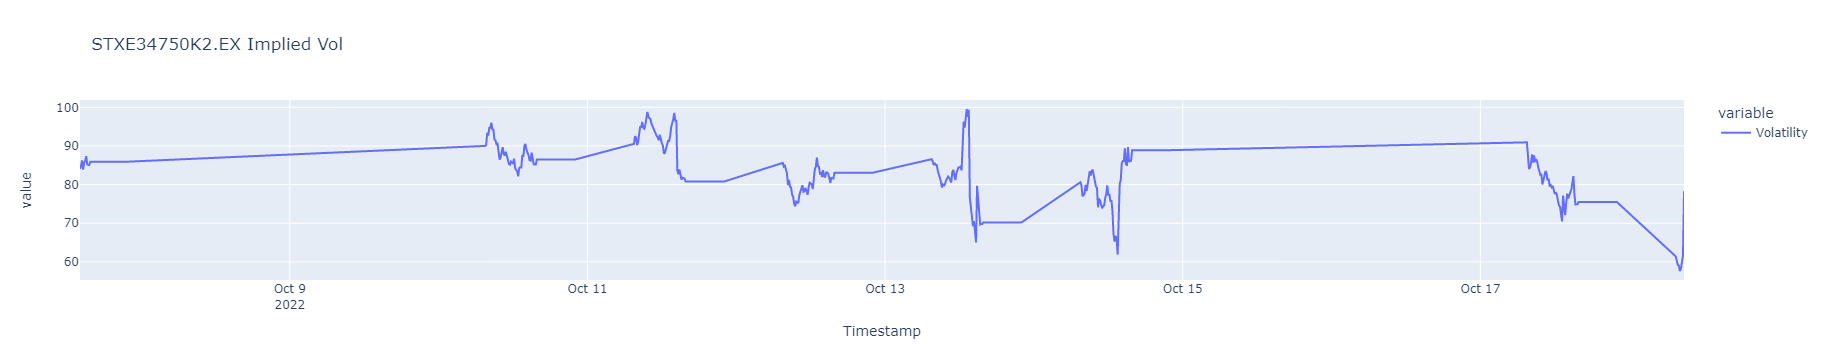

In [221]:
fig = px.line(IPADf['Volatility'], title = IPADf.columns.name + " Implied Vol")  # This is just to see the implied vol graph when that field is available
fig.show()

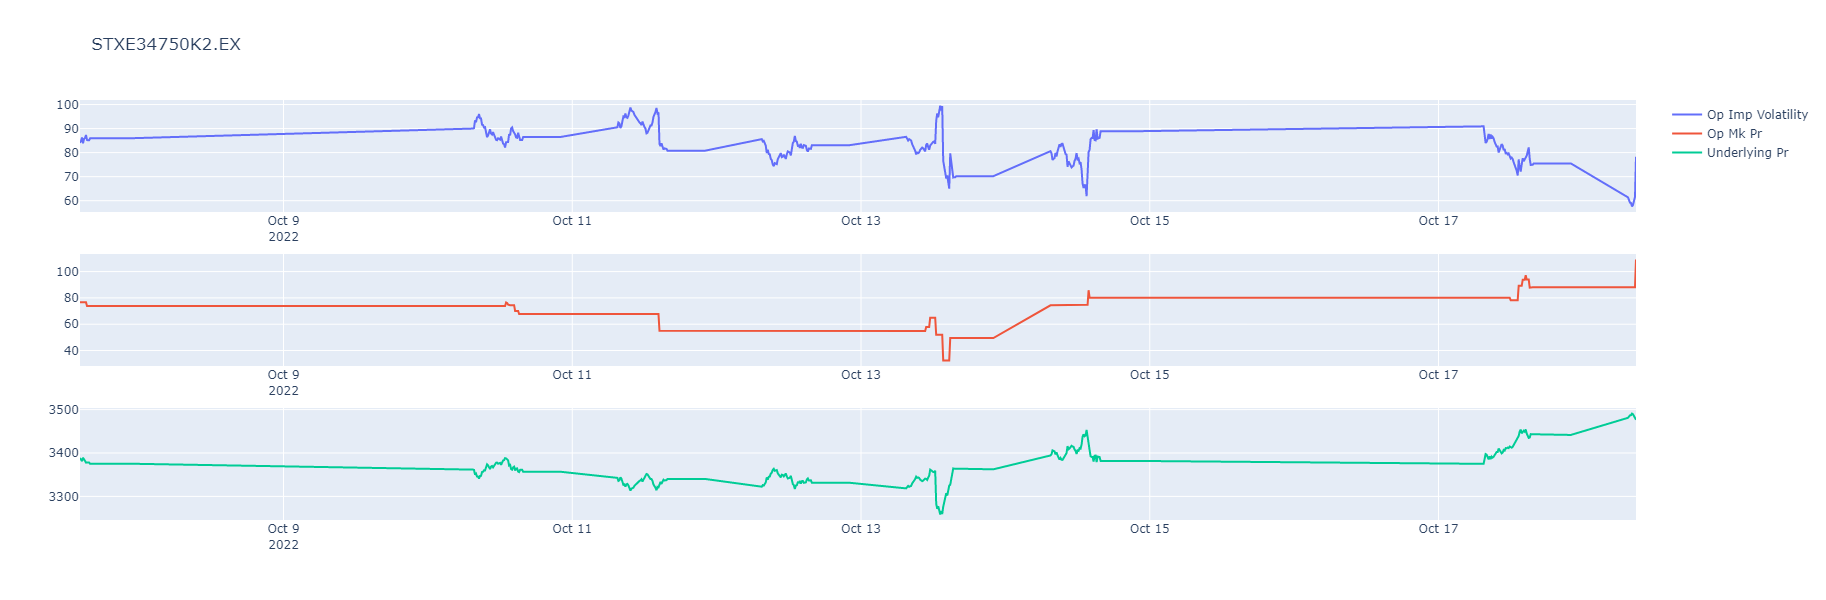

[Error 400 - invalid_grant] empty error description


In [222]:
fig = make_subplots(rows=3, cols=1)

fig.add_trace(go.Scatter(x=IPADf.index, y=IPADf.Volatility, name='Op Imp Volatility'), row=1, col=1)
fig.add_trace(go.Scatter(x=IPADf.index, y=IPADf.MarketValueInDealCcy, name='Op Mk Pr'), row=2, col=1)
fig.add_trace(go.Scatter(x=IPADf.index, y=IPADf.UnderlyingPrice, name='Underlying Pr'), row=3, col=1)


fig.update(layout_xaxis_rangeslider_visible=False)
fig.update_layout(title=IPADf.columns.name)
fig.update_layout(
    autosize=False,
    # width=1400,
    height=600)
fig.show()

# End

In [ ]:
# import refinitiv.data as rd
# from refinitiv.data.content import search
# rd.open_session()
# response4 = search.Definition(
#             query = "BARC.L",
#             select= "DocumentTitle, RIC, StrikePrice, ExchangeCode",
#             filter= "RCSAssetCategoryLeaf eq 'Option' and RIC eq 'BARC*' and DocumentTitle ne '*Weekly*'  "+
#         "and CallPutOption eq 'Call' and ExchangeCode eq 'EUX'",
#             top = 10000,
#         ).get_data()
# response4.data.df

In [ ]:
IPADf = pd.DataFrame()

In [ ]:
responseDict = {'request_definition': [],
               'response': [],
               'headers_name': [],
               'responsedf': [],
               'IPADfi': [],
               'TRDPRC_1': [],
               'EurRfRate': [],
               'underlying TRDPRC_1': []}

In [ ]:
for i in range(len(df.index)):
    
    # Example request with Body Parameter - Symbology Lookup
    request_definition = rd.delivery.endpoint_request.Definition(
        method = rd.delivery.endpoint_request.RequestMethod.POST,
        url = 'https://api.refinitiv.com/data/quantitative-analytics/v1/financial-contracts',
        body_parameters = {
      "fields": [
        "MarketValueInDealCcy",
        "RiskFreeRatePercent",
        "UnderlyingPrice",
        "PricingModelType",
        "DividendType",
        "VolatilityType",
        "UnderlyingTimeStamp",
        "ReportCcy",
        "VolatilityType",
        "Volatility",
        "DeltaPercent",
        "GammaPercent",
        "RhoPercent",
        "ThetaPercent",
        "VegaPercent"
      ],
      "outputs": [
        "Data",
        "Headers"
      ],
      "universe": [
        {
          "instrumentType": "Option",
          "instrumentDefinition": {
            "buySell": "Buy",
            "underlyingType": "Eti",
            "instrumentCode": "STXE35500J2.EX"
          },
          "pricingParameters": {
            "marketValueInDealCcy": str(df['TRDPRC_1'][i]),
            "riskFreeRatePercent": str(df['EurRfRate'][i]),
            "underlyingPrice": str(df['underlying ' + underlying + ' TRDPRC_1'][i]),
            "pricingModelType": "BlackScholes",
            "dividendType": "ImpliedYield",
            "volatilityType": "Implied",
            "underlyingTimeStamp": "Default",
            "reportCcy": "EUR"
          }
        }
      ]
    }
    )

    response5 = request_definition.get_data()
    headers_name = [h['name'] for h in response5.data.raw['headers']]
    response5df = pd.DataFrame(data=response5.data.raw['data'], columns=headers_name)

    IPADf = IPADf.append(response5df)

    responseDict['request_definition'].append(request_definition)
    responseDict['response'].append(response)
    responseDict['headers_name'].append(headers_name)
    responseDict['responsedf'].append(responsedf)
    responseDict['IPADfi'].append(IPADf)
    responseDict['TRDPRC_1'].append(str(df['TRDPRC_1'][i]))
    responseDict['EurRfRate'].append(str(df['EurRfRate'][i]))
    responseDict['underlying TRDPRC_1'].append(str(df['underlying ' + underlying + ' TRDPRC_1'][i]))

In [ ]:
IPADf.index = df.index
IPADf.columns.name = df.columns.name

In [ ]:
IPADf

In [ ]:
fig = px.line(IPADf['Volatility'], title = IPADf.columns.name + " Implied Vol") # This is just to see the implied vol graph when that field is available
fig.show()

In [ ]:
from refinitiv.data.content.ipa.financial_contracts import option

In [ ]:
response = option.Definition(
    underlying_type=option.UnderlyingType.Eti,
    strike=K,
    underlying_definition=option.EtiUnderlyingDefinition(".STOXX50ER"),
    # notional_ccy="AUD",
    # tenor="5M",
    pricing_parameters=option.PricingParameters(
        marketValueInDealCcy=df['TRDPRC_1'][-1],
        # price_side=option.PriceSide.MID,
        valuation_date="2022-10-03",
        # fx_spot_object=option.BidAskMid(bid=0.7387, ask=0.7387, mid=0.7387),
        pricing_model_type=option.PricingModelType.BLACK_SCHOLES,
    )
).get_data()

response.data.df

In [ ]:
https://github.com/Refinitiv-API-Samples/Example.RDPAPI.Python.InstrumentPricingAnalytics/blob/main/financial-contracts/Equity%20Derivatives/Equity%20Listed%20Vanilla%20Option%20IV%20and%20Greeks.ipynb

In [ ]:
help(option)





The Black-Scholes model implies:

$C = \Phi(d_1) S - \Phi(d_2) K e^{-r t}$

Where:

* C is the market price of a call option
* P is the market price of a put option
* S is the stock price of the underlying stock
* K is the option's Strike Price
* t is the option's time to expiration (in years)
* r is the risk-free rate (annualised)
* $\sigma$ is the implied volatility and
* $\Phi()$ is the Normal Cumulative Distribution Function such that $\Phi(.) = \frac{1}{\sigma \sqrt{2 \pi}}$ using the drift, $r - \frac{\sigma^2}{2}$, as the mean; as can be found [online](https://en.wikipedia.org/wiki/Cumulative_distribution_function) and is explained well [here](https://www.math.kth.se/matstat/gru/sf2701/2015/lecture8.pdf).

In [ ]:
import numpy as np
from scipy.stats import norm

N_prime = norm.pdf
N = norm.cdf


def black_scholes_call(S, K, T, r, sigma):
    '''

    :param S: Asset price
    :param K: Strike price
    :param T: Time to maturity
    :param r: risk-free rate (treasury bills)
    :param sigma: volatility
    :return: call price
    '''

    ###standard black-scholes formula
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call = S * N(d1) -  N(d2)* K * np.exp(-r * T)
    return call

def vega(S, K, T, r, sigma):
    '''

    :param S: Asset price
    :param K: Strike price
    :param T: Time to Maturity
    :param r: risk-free rate (treasury bills)
    :param sigma: volatility
    :return: partial derivative w.r.t volatility
    '''

    ### calculating d1 from black scholes
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / sigma * np.sqrt(T)

    #see hull derivatives chapter on greeks for reference
    vega = S * N_prime(d1) * np.sqrt(T)
    return vega



def implied_volatility_call(C, S, K, T, r, tol=0.0001,
                            max_iterations=100):
    '''

    :param C: Observed call price
    :param S: Asset price
    :param K: Strike Price
    :param T: Time to Maturity
    :param r: riskfree rate
    :param tol: error tolerance in result
    :param max_iterations: max iterations to update vol
    :return: implied volatility in percent
    '''


    ### assigning initial volatility estimate for input in Newton_rap procedure
    sigma = 0.3
    
    for i in range(max_iterations):

        ### calculate difference between blackscholes price and market price with
        ### iteratively updated volality estimate
        diff = black_scholes_call(S, K, T, r, sigma) - C

        ###break if difference is less than specified tolerance level
        if abs(diff) < tol:
            print(f'found on {i}th iteration')
            print(f'difference is equal to {diff}')
            break

        ### use newton rapshon to update the estimate
        sigma = sigma - diff / vega(S, K, T, r, sigma)

    return sigma

In [ ]:
implied_volatility_call(
    C = df2.iloc[0,0],
    S = ,
    K = ,
    T = ,
    r = ,
    tol=0.0001,
    max_iterations=100)

In [ ]:
_underlyingMrktPrice = rd.get_history(
    universe=[underlying],
    fields=["TRDPRC_1"],
    interval="10min",
    start=(datetime.strptime(start, '%Y-%m-%dT%H:%M:%S.%f') - timedelta(days=30)).strftime('%Y-%m-%dT%H:%M:%S'),
    end=end)

In [ ]:
_underlyingMrktPrice

let's put it all together

In [ ]:
datetime.strptime(start, '%Y-%m-%dT%H:%M:%S.%f') - datetime.strptime(end, '%Y-%m-%dT%H:%M:%S.%f')

In [ ]:
# _underlyingMrktPrice['log_ret'] = np.log(_underlyingMrktPrice.TRDPRC_1) - np.log(_underlyingMrktPrice.TRDPRC_1.shift(1))

We use 252 business days a year as is the [standard](https://www.investopedia.com/ask/answers/021015/how-can-you-calculate-volatility-excel.asp):

In [ ]:
_underlyingMrktPrice.TRDPRC_1.rolling(window=30).std(ddof=0)*np.sqrt(252)

In [ ]:
How to annualize intra-day volatility on minute data?: https://quant.stackexchange.com/questions/2539/how-to-annualize-intra-day-volatility-on-minute-data

https://pypi.org/project/hffe/

file:///C:/Users/U6082174/Downloads/mathematics-09-00320-v2.pdf

https://www.emmi-benchmarks.eu/benchmarks/euribor/#:~:text=Euribor%C2%AE%20is%20published%20every,for%20each%20of%20its%20tenors.

Don't forget to Answer: https://quant.stackexchange.com/questions/39988/which-volatility-as-input-in-black-scholes-formula
and: https://quant.stackexchange.com/questions/70122/realized-volatility-calculation-in-python
https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model

## References

[What is the RIC syntax for options in Refinitiv Eikon?](https://my.refinitiv.com/content/mytr/en/faqs/2016/09/000195632.html)

[Functions to find Option RICs traded on different exchanges](https://developers.refinitiv.com/en/article-catalog/article/functions-to-find-option-rics-traded-on-different-exchanges#2.4-Function-for-the-EUREX)

[Eikon Calc Help Page](https://emea1.apps.cp.thomsonreuters.com/Apps/AdfinLibrary/?cshid=AdBondDeriv&srv=PLNP-ERPCPRP04)

### Q&A

[RIC nomenclature for expired Options on Futures](https://community.developers.refinitiv.com/questions/82796/ric-nomenclature-for-expired-options-on-futures.html)

[Expiration Dates for Expired Options API](https://community.developers.refinitiv.com/questions/69830/expiration-dates-for-expired-options-api.html)